**Table of Contents:**
* [How to use the FGS Commissioning Tool](#CommTool)
 * [Example: CMIMF + FGS](#CMIMFFGS)
 * [Example: GA + NIRCam](#GANIRCam)
* [Rewriting .prc files only (for iterative DHAS testing)](#rewriteprc)
* [Converting NIRCam to FGS outside of the tool](#nircamtofgs)

<a id='CommTool'></a>
# How to use the FGS Commissioning Tool

In [1]:
import run_fgs_commissioning_tool

In [2]:
import os
from glob import glob
from astropy.io import fits
from astropy.io import ascii as asc
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
% matplotlib inline

The tool takes a number of arguments:
* The `input_image` (filepath) and `guider` number are required. 
* The `root` argument, defined, will be used to create the output directory, `./out/{root}`. If not provided, the root name will be derived from the `input_image` filename.
* The `nircam` flag denotes if the `input_image` is an FGS or NIRCam image. If `True`, the image will be converted to FGS format using the `nircam_to_fgs.convert_im` function. The FGS-formatted image will be saved to `./out/{input_image}/FGS_imgs/{input_image}_binned_pad_norm.fits`
* The `nircam_mod` argument can be used to specify the module of a provided NIRCam image. If left blank, the module will be extracted from the header of the NIRCam FITS file.
* The `fgs_counts` and `jmag` parameters are used to normalize the input NIRCam image, either to a desired J magnitude or to a desired number of FGS counts. The `jmag` parameter can also be used to normalize an FGS image.
* If the provided image is from global alignment, set the `global_alignment` parameter to be `True`, or the PSF-finding algorithm will go haywire.

Unless otherwise specified, the tool will prompt the user to select guide and reference stars interactively with a GUI:
<img src="FGSCommTools_GUI.png">
* If you want to bypass the GUI and provide the (x, y) locations and countrates of the guide star and reference star with an incat file or a regfile, provide the appropriate filepath to the `in_file` argument.

<a id='CMIMFFGS'></a>
### Example: FGS CMIMF Image

In [5]:
input_image_fgs_cmimf = '/user/lchambers/FGS/tool_tutorial/FGS_files/CMIF.fits'
guider = 1
root_fgs_cmimf = 'tool_tutorial_fgscmimf'

NC = False
nircam_mod = None # default

fgs_counts = None # default
jmag = None # default

GA = False # default

bkgd_stars = False # default

in_file = None # default

When the `run_fgs_commissioning_tool.run_all()` function is called, the following files will be created in the `out/{root}` directory:
* `reg_file.txt` - a list of the pixel coordinates and 3x3 countrate sums of the selected guide and reference stars
* `ALLpsfs.txt` - a list of the pixel coordinates, 3x3 countrate sums, and segment identifier (letter label) of all PSFs found in the image
* `centers.png` - a saved image of the input FGS file, annotated with the locations of all PSFs found in the image
* ID Mode:
 * `sky.fits` (the input file after being time-normalized (converted from counts/s to counts)
 * `bias.fits` (bias file used to create noisy FGS image)
 * `cds.fits` (correlated double sample)
 * `ff.fits` (full frame; image before CDS)
 * `strips.fits` (strips to run in DHAS)
 * `strips.dat` (strips to run in FGSES)
 * `.gssscat`
 * `.stc`
 * `.prc` (to run in DHAS or FGSES)
* ACQ Mode (each for ACQ1 and ACQ2):
 * `sky.fits` (the input file after being time-normalized (converted from counts/s to counts)
 * `bias.fits` (bias file used to create noisy FGS image)
 * `cds.fits` (correlated double sample)
 * `.fits` (to run in DHAS)
 * `.dat` (to run in FGSES)
 * `.cat`
 * `.stc`
 * `.prc` (to run in DHAS or FGSES)
* LOSTRK:
 * `.fits`
 * `.dat` (to run in FGSES)
* TRK:
 * `.fits` (to run in DHAS)

In [9]:
run_fgs_commissioning_tool.run_all(input_image_fgs_cmimf, guider, root=root_fgs_cmimf, nircam=NC)

/Users/lchambers/TEL/FGS/Commissioning-tools/logs/2018_01_17_Wed_174703_run_all_tool_tutorial_fgscmimf.log
2018-01-17 17:47:03,561 INFO     Started logging to /Users/lchambers/TEL/FGS/Commissioning-tools/logs/2018_01_17_Wed_174703_run_all_tool_tutorial_fgscmimf.log
2018-01-17 17:47:03,562 INFO     Processing request for tool_tutorial_fgscmimf. 
All data will be saved in: /Users/lchambers/TEL/FGS/Commissioning-tools/out/tool_tutorial_fgscmimf
2018-01-17 17:47:03,563 INFO     Input image: /user/lchambers/FGS/tool_tutorial/FGS_files/CMIF.fits
2018-01-17 17:47:03,564 INFO     This is a FGS image
2018-01-17 17:47:04,351 INFO     15 PSFs detected in Gaussian-smoothed data             (threshold = 64.15323374126031; sigma = 5)
2018-01-17 17:47:12,507 INFO     1 guide star and 4 reference stars selected
2018-01-17 17:47:13,402 INFO     Max of input image: 15693
2018-01-17 17:47:13,403 INFO     Using /Users/lchambers/TEL/FGS/Commissioning-tools/out/tool_tutorial_fgscmimf/tool_tutorial_fgscmimf_

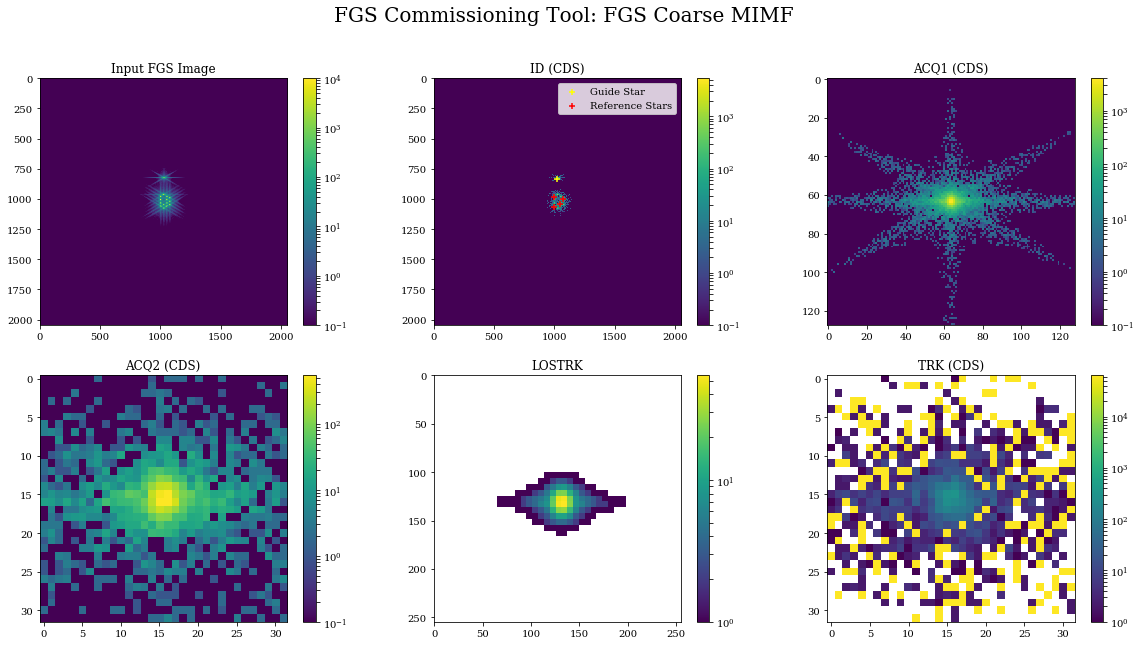

In [10]:
# View the final FGS images
current_dir = os.getcwd()
out_dir = os.path.join(current_dir, 'out', root_fgs_cmimf)

fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('FGS Commissioning Tool: FGS Coarse MIMF', fontsize=20)

in_data = fits.open(input_image_fgs_cmimf)[1].data
in_data[in_data <= 0] = 0.1
implot = ax1.imshow(in_data, norm=LogNorm(), clim=(1e-1, 1e4))
plt.colorbar(implot, ax=ax1)
ax1.set_title('Input FGS Image')

id_data = fits.open(glob(out_dir + '/stsci/*IDcds.fits')[0])[0].data[0]
id_data[id_data <= 0] = 0.1
implot = ax2.imshow(id_data, norm=LogNorm())
plt.colorbar(implot, ax=ax2)
regfile = glob(out_dir + '/*regfile.txt')[0]
coords = asc.read(regfile)
ax2.scatter(coords['x'][0], coords['y'][0], marker = '+', c= 'yellow', label='Guide Star')
ax2.scatter(coords['x'][1:], coords['y'][1:], marker = '+', c= 'r', label='Reference Stars')
ax2.legend()
ax2.set_title('ID (CDS)')

acq1_data = fits.open(glob(out_dir + '/stsci/*ACQ1cds.fits')[0])[0].data[0]
acq1_data[acq1_data <= 0] = 0.1
implot = ax3.imshow(acq1_data, norm=LogNorm())
plt.colorbar(implot, ax=ax3)
ax3.set_title('ACQ1 (CDS)')

acq2_data = fits.open(glob(out_dir + '/stsci/*ACQ2cds.fits')[0])[0].data[0]
acq2_data[acq2_data <= 0] = 0.1
implot = ax4.imshow(acq2_data, norm=LogNorm())
plt.colorbar(implot, ax=ax4)
ax4.set_title('ACQ2 (CDS)')

lostrk_data = fits.open(glob(out_dir + '/dhas/*LOSTRK.fits')[0])[0].data[0]
lostrk_data[lostrk_data <= 0] = 0.1
implot = ax5.imshow(lostrk_data, norm=LogNorm())
plt.colorbar(implot, ax=ax5)
ax5.set_title('LOSTRK')

trk_data = fits.open(glob(out_dir + '/dhas/*_TRK.fits')[0])[0].data
trk_data = trk_data[1] - trk_data[0]
trk_data[trk_data <= 0] = 0.1
implot = ax6.imshow(trk_data, norm=LogNorm())
plt.colorbar(implot, ax=ax6)
ax6.set_title('TRK (CDS)')

plt.show()

<a id='GANIRCam'></a>
### Example: NIRCam Global Alignment Image

In [12]:
input_image_nc_ga = '/user/lchambers/FGS/tool_tutorial/NIRCam_files/jw00000_100_001_01100_00001_NRCA3_img.fits'
guider = 1
root_nc_ga = 'tool_tutorial_ncga'

NC = True # default
nircam_mod = None # default

fgs_counts = None # default
jmag = None # default

GA = True

bkgd_stars = False # default

in_file = None # default

In [13]:
run_fgs_commissioning_tool.run_all(input_image_nc_ga, guider, root=root_nc_ga, global_alignment=GA, nircam=NC)

/Users/lchambers/TEL/FGS/Commissioning-tools/logs/2018_01_17_Wed_174808_run_all_tool_tutorial_ncga.log
2018-01-17 17:48:08,280 INFO     Started logging to /Users/lchambers/TEL/FGS/Commissioning-tools/logs/2018_01_17_Wed_174808_run_all_tool_tutorial_ncga.log
2018-01-17 17:48:08,281 INFO     Processing request for tool_tutorial_ncga. 
All data will be saved in: /Users/lchambers/TEL/FGS/Commissioning-tools/out/tool_tutorial_ncga
2018-01-17 17:48:08,281 INFO     Input image: /user/lchambers/FGS/tool_tutorial/NIRCam_files/jw00000_100_001_01100_00001_NRCA3_img.fits
2018-01-17 17:48:08,282 INFO     This is a NIRCam image
2018-01-17 17:48:08,283 WARNING  No counts or J magnitude given, setting to default
2018-01-17 17:48:08,284 INFO     J magnitude = 11.0
2018-01-17 17:48:08,285 INFO     Beginning to create FGS image from jw00000_100_001_01100_00001_NRCA3_img
Removing pedestal 1 value: 9.054266868512054
Removing pedestal 2 value: 9.6016587370243
Removing pedestal 3 value: 9.765120025951237
Rem

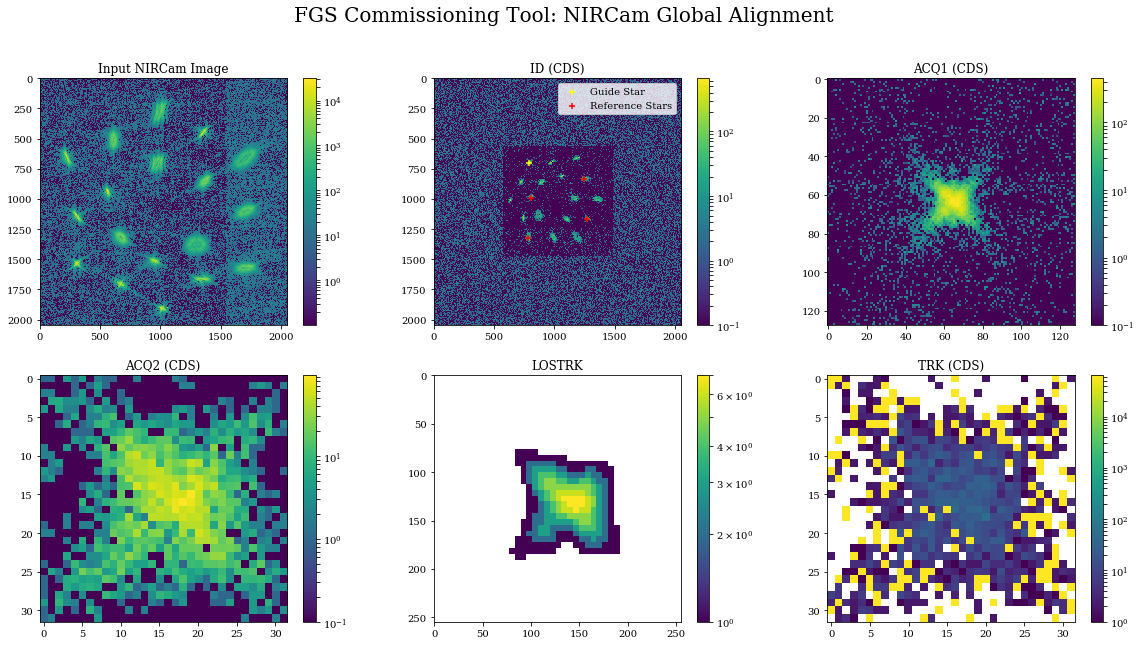

In [14]:
# View the final FGS images
current_dir = os.getcwd()
out_dir = os.path.join(current_dir, 'out', root_nc_ga)

fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('FGS Commissioning Tool: NIRCam Global Alignment', fontsize=20)

in_data = fits.open(input_image_nc_ga)[1].data
in_data[in_data <= 0] = 0.1
implot = ax1.imshow(in_data, norm=LogNorm())
plt.colorbar(implot, ax=ax1)
ax1.set_title('Input NIRCam Image')

id_data = fits.open(glob(out_dir + '/stsci/*IDcds.fits')[0])[0].data[0]
id_data[id_data <= 0] = 0.1
implot = ax2.imshow(id_data, norm=LogNorm())
plt.colorbar(implot, ax=ax2)
regfile = glob(out_dir + '/*regfile.txt')[0]
coords = asc.read(regfile)
ax2.scatter(coords['x'][0], coords['y'][0], marker = '+', c= 'yellow', label='Guide Star')
ax2.scatter(coords['x'][1:], coords['y'][1:], marker = '+', c= 'r', label='Reference Stars')
ax2.legend()
ax2.set_title('ID (CDS)')

acq1_data = fits.open(glob(out_dir + '/stsci/*ACQ1cds.fits')[0])[0].data[0]
acq1_data[acq1_data <= 0] = 0.1
implot = ax3.imshow(acq1_data, norm=LogNorm())
plt.colorbar(implot, ax=ax3)
ax3.set_title('ACQ1 (CDS)')

acq2_data = fits.open(glob(out_dir + '/stsci/*ACQ2cds.fits')[0])[0].data[0]
acq2_data[acq2_data <= 0] = 0.1
implot = ax4.imshow(acq2_data, norm=LogNorm())
plt.colorbar(implot, ax=ax4)
ax4.set_title('ACQ2 (CDS)')

lostrk_data = fits.open(glob(out_dir + '/dhas/*LOSTRK.fits')[0])[0].data[0]
lostrk_data[lostrk_data <= 0] = 0.1
implot = ax5.imshow(lostrk_data, norm=LogNorm())
plt.colorbar(implot, ax=ax5)
ax5.set_title('LOSTRK')

trk_data = fits.open(glob(out_dir + '/dhas/*_TRK.fits')[0])[0].data
trk_data = trk_data[1] - trk_data[0]
trk_data[trk_data <= 0] = 0.1
implot = ax6.imshow(trk_data, norm=LogNorm())
plt.colorbar(implot, ax=ax6)
ax6.set_title('TRK (CDS)')

plt.show()

<a id='rewriteprc'></a>
# For iterative DHAS testing: updating the .prc files without re-running the whole tool

If you are testing, say, a range of geometries for guide and reference stars on a single global alignment ID image in the DHAS, it would be obnoxious and cumbersome to re-run the entire tool every time you just want to command a different set of guide/reference stars. The only thing that needs to be re-written in this case is the `.prc` file; the output `.fits` image that is fed into DHAS will be the same.

There is a stand-alone script, `DHAStesting_prc.py` that can be used in cases like this, which just re-write the `.prc` file according to user input.

The user input is provided as a series of letters, corresponding to segments of JWST as shown below. The first letter corresponds to the guide star segment.
<img src="JWSTgrid.png" style="width: 400px;">

In [149]:
import DHAStesting_prc

In [152]:
guider = 1
root = 'tool_tutorial_gafgs' # MUST match the root of the file you are trying to alter
out_dir = os.path.join(current_dir, 'out', root) # Where to find the prc

thresh_factor = 0.9 # default
# The thresh_factor is the percentage of the PSF countrate that is used as DHAS threshold. 
# (e.g. if thresh_factor is 0.9 and the countrate is 100, the threshold provided to DHAS will be 90)

order = 'OPHIA'

DHAStesting_prc.rewrite_prc(order, guider, root, out_dir)

Reading from (and writing to) /Users/lchambers/TEL/FGS/Commissioning-tools/out/tool_tutorial_gafgs
Threshold: 0.9
Number of reference stars: 4
Successfully wrote: tool_tutorial_gafgs_G1_ID.prc


<a id='nircamtofgs'></a>
# How to convert NIRCam images to FGS images outside of the tool: nircam_to_fgs.py

The `nircam_to_fgs` function takes the following arguments:
* The `input_image` (filepath, directory, or list of filepaths) and `guider` number are required. 
* The `nircam_mod` argument can be used to specify the module of a provided NIRCam image. If left blank, the module will be extracted from the header of the NIRCam FITS file.
* The `fgs_counts` and `jmag` parameters are used to normalize the input NIRCam image, either to a desired J magnitude or to a desired number of FGS counts. If neither are defined, the tool will use a default of jmag = 11.
* If `return_im` is set to `True`, then the function call will output the array of output images.
* The output FGS image(s) will be saved to `output_path`. If the output path is not provided, the image(s) will be saved to `./out/{input_image}`.

**Note:** Like the full tool, running nircam_to_fgs.py will create an `out` directory (whether you want it to or not) in the directory where you are running this script. Inside the `./out/` directory will be directories for every image that you run the script for, with the output FGS `bin_norm_img.fits` inside.

In [15]:
import nircam_to_fgs

In [16]:
input_im = '/user/lchambers/FGS/tool_tutorial/NIRCam_files/' # Providing a directory
guider = 2

fgs_counts = None # default
jmag = None # default

nircam_mod = None # default

return_im = True # default
output_path = None # default

In [19]:
fgs_im = nircam_to_fgs.convert_im(input_im, guider, return_im=True, output_path=None)

2018-01-17 17:51:37,237 WARNING  No counts or J magnitude given, setting to default
2018-01-17 17:51:37,238 INFO     J magnitude = 11.0
2018-01-17 17:51:37,242 INFO     Beginning to create FGS image from jw00000_231_001_01100_00000_NRCA3_img
Successfully wrote: /Users/lchambers/TEL/FGS/Commissioning-tools/out/jw00000_231_001_01100_00000_NRCA3_img/FGS_imgs/jw00000_231_001_01100_00000_NRCA3_img_G2_binned_pad_norm.fits
Finished for jw00000_231_001_01100_00000_NRCA3_img, Guider = 2
2018-01-17 17:51:40,022 INFO     Beginning to create FGS image from jw00000_231_001_01100_00001_NRCA3_img
Successfully wrote: /Users/lchambers/TEL/FGS/Commissioning-tools/out/jw00000_231_001_01100_00001_NRCA3_img/FGS_imgs/jw00000_231_001_01100_00001_NRCA3_img_G2_binned_pad_norm.fits
Finished for jw00000_231_001_01100_00001_NRCA3_img, Guider = 2
2018-01-17 17:51:42,723 INFO     Beginning to create FGS image from jw00000_100_001_01100_00001_NRCA3_img
Successfully wrote: /Users/lchambers/TEL/FGS/Commissioning-tools

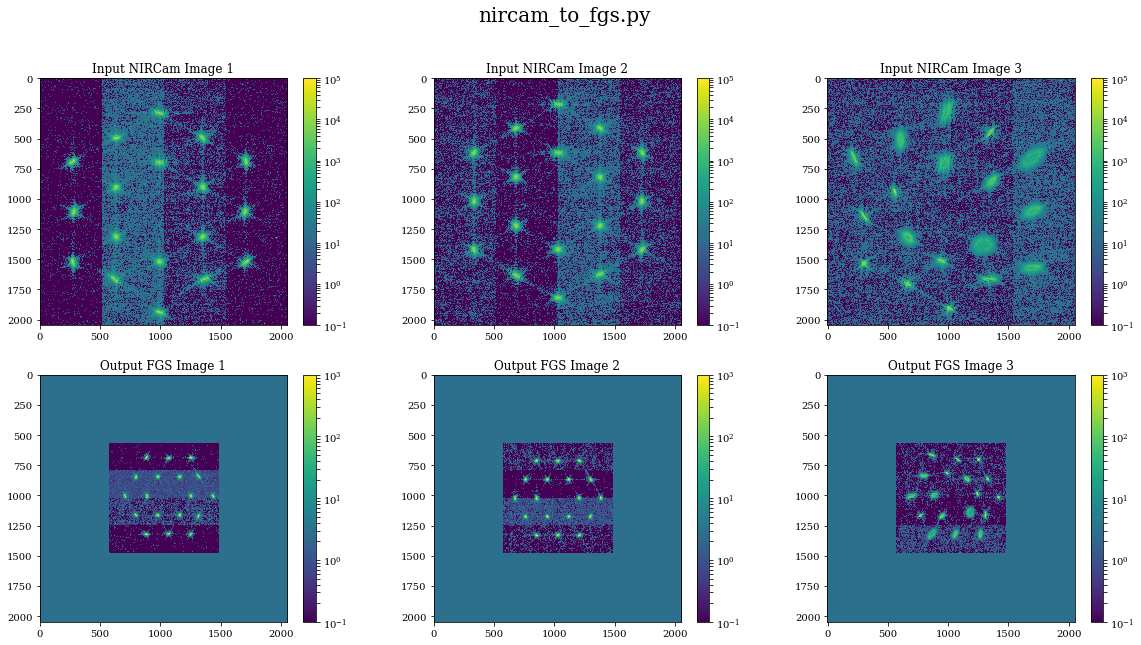

In [21]:
# View the input NIRCam images and output FGS images
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('nircam_to_fgs.py', fontsize=20)

in_files = glob(input_im + '*.fits')
nircam_clim = (1e-1, 1e5)

in_data1 = fits.open(in_files[0])[1].data
in_data1[in_data1 <= 0] = 0.1
implot = ax1.imshow(in_data1, norm=LogNorm(), clim=nircam_clim)
plt.colorbar(implot, ax=ax1)
ax1.set_title('Input NIRCam Image 1')

in_data2 = fits.open(in_files[1])[1].data
in_data2[in_data2 <= 0] = 0.1
implot = ax2.imshow(in_data2, norm=LogNorm(), clim=nircam_clim)
plt.colorbar(implot, ax=ax2)
ax2.set_title('Input NIRCam Image 2')

in_data3 = fits.open(in_files[2])[1].data
in_data3[in_data3 <= 0] = 0.1
implot = ax3.imshow(in_data3, norm=LogNorm(), clim=nircam_clim)
plt.colorbar(implot, ax=ax3)
ax3.set_title('Input NIRCam Image 3')

fgs_clim = (1e-1, 1e3)

out_data1 = fgs_im[0]
out_data1[out_data1 <= 0] = 0.1
implot = ax4.imshow(out_data1, norm=LogNorm(), clim=fgs_clim)
plt.colorbar(implot , ax=ax4)
ax4.set_title('Output FGS Image 1')

out_data2 = fgs_im[1]
out_data2[out_data2 <= 0] = 0.1
implot = ax5.imshow(out_data2, norm=LogNorm(), clim=fgs_clim)
plt.colorbar(implot, ax=ax5)
ax5.set_title('Output FGS Image 2')

out_data3 = fgs_im[2]
out_data3[out_data3 <= 0] = 0.1
implot = ax6.imshow(out_data3, norm=LogNorm(), clim=fgs_clim)
plt.colorbar(implot, ax=ax6)
ax6.set_title('Output FGS Image 3')

plt.show()